# Data Science & LLM Technical Assessment

Joseph Farrington, June 2025

In [ ]:
# Set up if using Google Colab
# Ollama elements based on https://medium.com/google-cloud/gemma-3-ollama-on-colab-a-developers-quickstart-7bbf93ab8fef
import sys
import os
if 'google.colab' in sys.modules:
  # Clone the repository and install dependencies
  !git -C hospital_stay_exercise pull || git clone https://github.com/joefarrington/hospital_stay_exercise hospital_stay_exercise;
  os.chdir("hospital_stay_exercise")
  !pip install uv;
  !uv pip install --system . 

  # Install Ollama and download model parameters
  !curl -fsSL https://ollama.com/install.sh | sh
  !nohup ollama serve &
  !ollama pull llama3.2:3b

## 1. Predictive Modelling (Binary Classification)

### Set-up and preliminary EDA

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import mlflow


from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.inspection import permutation_importance

SEED = 5

In [3]:
# Load data
data_fp = Path("data/Assignment_Data.csv")
data = pd.read_csv(data_fp)

In [4]:
# View example data
data.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


In [5]:
# View data types and counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               200 non-null    int64 
 1   age                      200 non-null    int64 
 2   gender                   200 non-null    object
 3   diagnosis_code           200 non-null    object
 4   num_previous_admissions  200 non-null    int64 
 5   medication_type          200 non-null    object
 6   length_of_stay           200 non-null    int64 
 7   readmitted_30_days       200 non-null    int64 
 8   discharge_note           200 non-null    object
dtypes: int64(5), object(4)
memory usage: 14.2+ KB


In [6]:
# View summary statistics for numeric columns
data.describe()

,patient_id,age,num_previous_admissions,length_of_stay,readmitted_30_days
count,200.000000,200.000000,200.000000,200.000000,200.00000
mean,100.500000,53.720000,1.600000,7.865000,0.32500
std,57.879185,21.294574,1.310951,4.134276,0.46955
min,1.000000,20.000000,0.000000,1.000000,0.00000
25%,50.750000,34.000000,1.000000,4.000000,0.00000
50%,100.500000,54.000000,1.000000,8.000000,0.00000
75%,150.250000,73.000000,2.000000,11.000000,1.00000
max,200.000000,89.000000,6.000000,14.000000,1.00000


In [7]:
# Check if each row has a unique patient ID
len(data['patient_id'].unique())

200

In [8]:
# Check class imbalance in the label column
data['readmitted_30_days'].value_counts(normalize=True)

readmitted_30_days
0    0.675
1    0.325
Name: proportion, dtype: float64

In [9]:
# Find out unique values for 'gender' column
data['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [10]:
# Find out unique values of 'diagnosis_code' column
data['diagnosis_code'].unique()

array(['D002', 'D001', 'D004', 'D003'], dtype=object)

In [11]:
# Find out unique values of the 'medication_type' column
data['medication_type'].unique()

array(['Type C', 'Type B', 'Type A'], dtype=object)

In [12]:
# Find out unique values of the 'diacharge_note' column
data['discharge_note'].unique()

array(['Good recovery trajectory. Follow-up scan scheduled next month.',
       'Stable post-surgery. Advised to avoid physical exertion.',
       'Symptoms controlled. Monitoring for relapse advised.',
       'Discharge after recovery from pneumonia. No complications observed.',
       'Patient discharged in stable condition. Recommend follow-up in 2 weeks.',
       'Patient showed improvement. Prescribed antibiotics for 5 days.',
       'Blood pressure under control. Continue current medication.',
       'Patient discharged with minor discomfort. Advised rest and hydration.',
       'No further signs of infection. Resume normal diet and activity.',
       'Mild reaction to medication. Switched to alternative treatment.'],
      dtype=object)

All of the patient_ids are unique. There is no data on admission/discharge time to allow temporal validation. There is class imbalance in the label, but it is not extreme (67.5% not readmitted within 30 days/32.5% readmitted within 30 days). Therefore I split the data into training and test set randomly, but stratified by the label column so the training and test sets have approximately equal ratios of labels. 

Values for age, num_previous_admissions, length_of_stay all have no missing values and are in reasonable ranges (e.g. no negative values, highest age 89 years). The categorical features have no missing values and are all low cardinality.

I conducted the remaining EDA on the training set only to avoid data leakage.

In [13]:
# Split the data into training and test sets
test_size = 0.2
target_column = 'readmitted_30_days'

train_data, test_data = train_test_split(
    data.set_index('patient_id'),
    test_size=test_size,
    random_state=SEED
)

X_train = train_data.drop(columns=[target_column])
y_train = train_data.loc[:,target_column]
X_test = test_data.drop(columns=[target_column])
y_test = test_data.loc[:, target_column]

### EDA on training data

#### Numeric features

<Axes: xlabel='length_of_stay', ylabel='Count'>

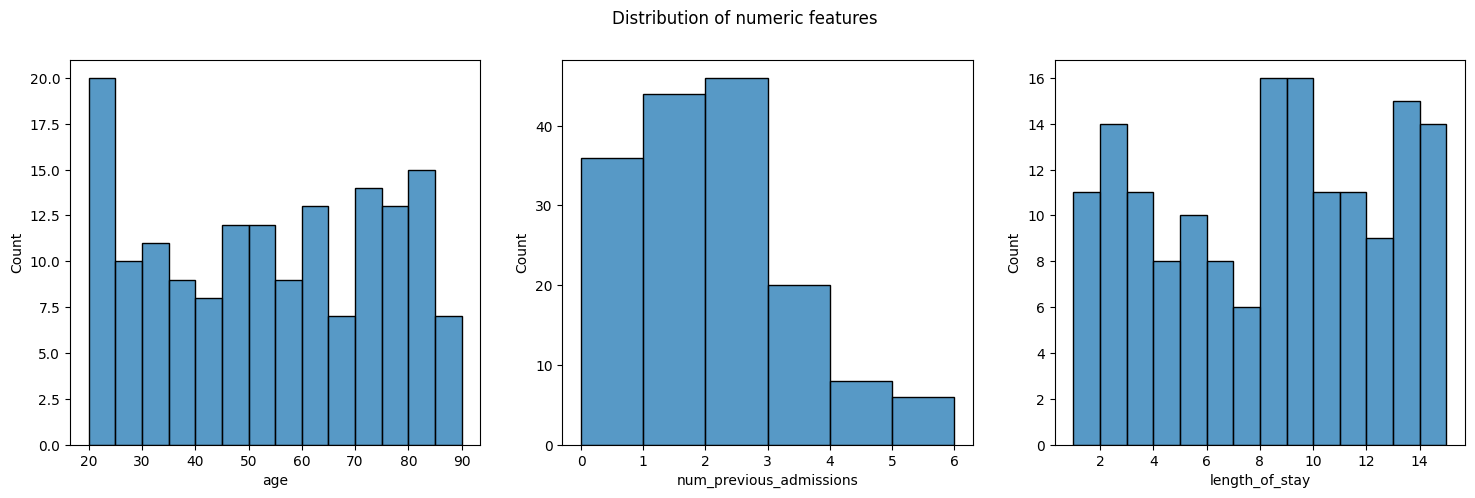

In [14]:
# Plot histograms of numeric features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of numeric features')
sns.histplot(train_data['age'], bins=range(20,95,5), ax=axes[0])
sns.histplot(train_data['num_previous_admissions'], bins=range(0,7,1), ax=axes[1])
sns.histplot(train_data['length_of_stay'], bins=range(1,16,1), ax=axes[2])

<Axes: xlabel='length_of_stay', ylabel='Count'>

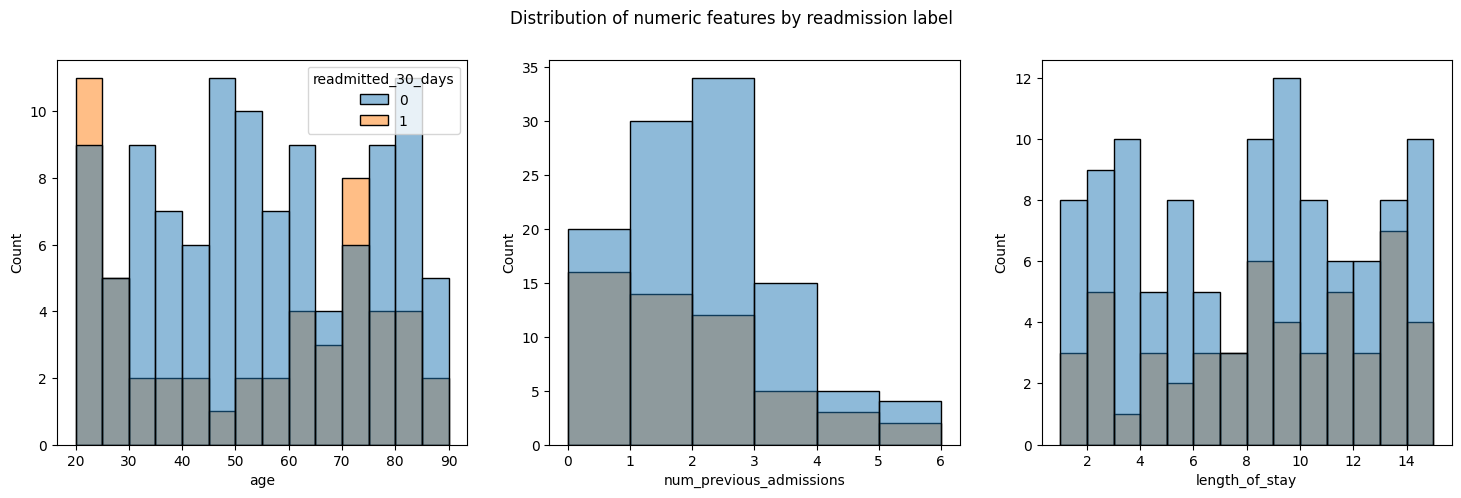

In [15]:
# Plot histograms of numeric features split by readmission label
train_readmitted = train_data[train_data[target_column] == 1]
train_not_readmitted = train_data[train_data[target_column] == 0]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of numeric features by readmission label')
sns.histplot(data=train_data, x='age', bins=range(20,95,5), ax=axes[0], hue='readmitted_30_days')
sns.histplot(data=train_data, x='num_previous_admissions', bins=range(0,7,1), ax=axes[1], hue='readmitted_30_days', legend=False)
sns.histplot(data=train_data, x='length_of_stay', bins=range(1,16,1), ax=axes[2], hue='readmitted_30_days', legend=False)

There is some information relevant to readmission in individual numeric features - for example, a majority of patients between 20-25 were readmitted, compared to a very low percentage between 30-60 years old, and a higher proportion of patients with 0 previous admissions were admitted than for patients with more prevous admissions.

The relationship between age and the need for readmission is clearly not monotonic.

#### Categorical features

<Axes: xlabel='medication_type', ylabel='count'>

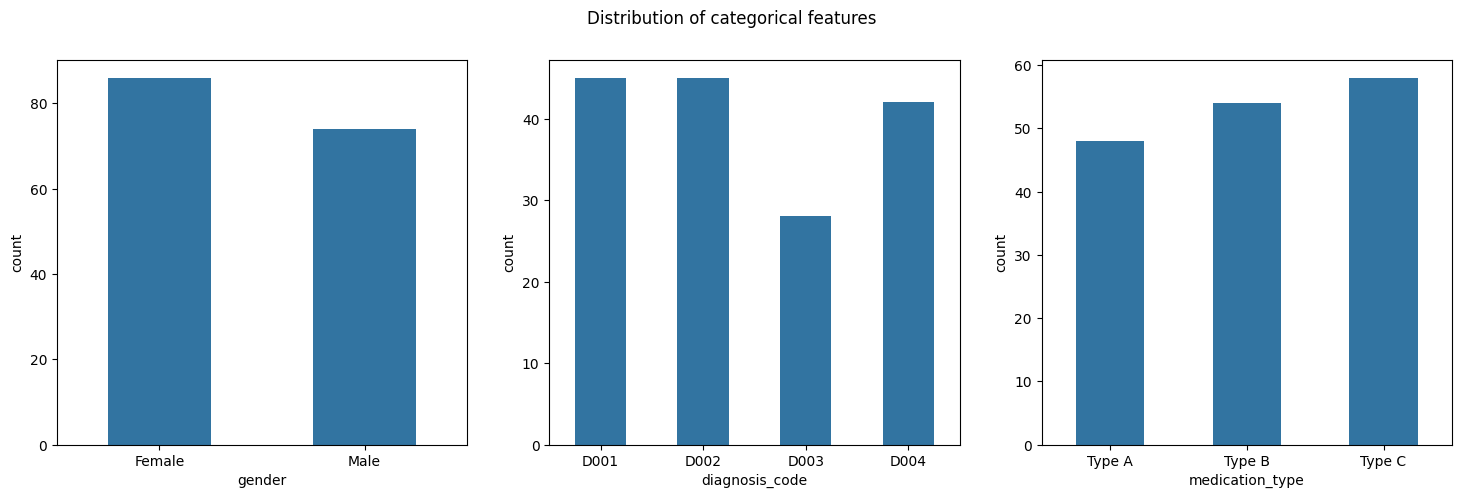

In [16]:
# Plot bar charts showing the count of each level of the categorical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of categorical features')
sns.barplot(train_data['gender'].value_counts(), ax=axes[0], width=0.5)
sns.barplot(train_data['diagnosis_code'].value_counts(), ax=axes[1], order=['D001', 'D002', 'D003', 'D004'], width=0.5)
sns.barplot(train_data['medication_type'].value_counts(), ax=axes[2], order=['Type A', 'Type B', 'Type C'], width=0.5)

Text(0, 0.5, 'proportion')

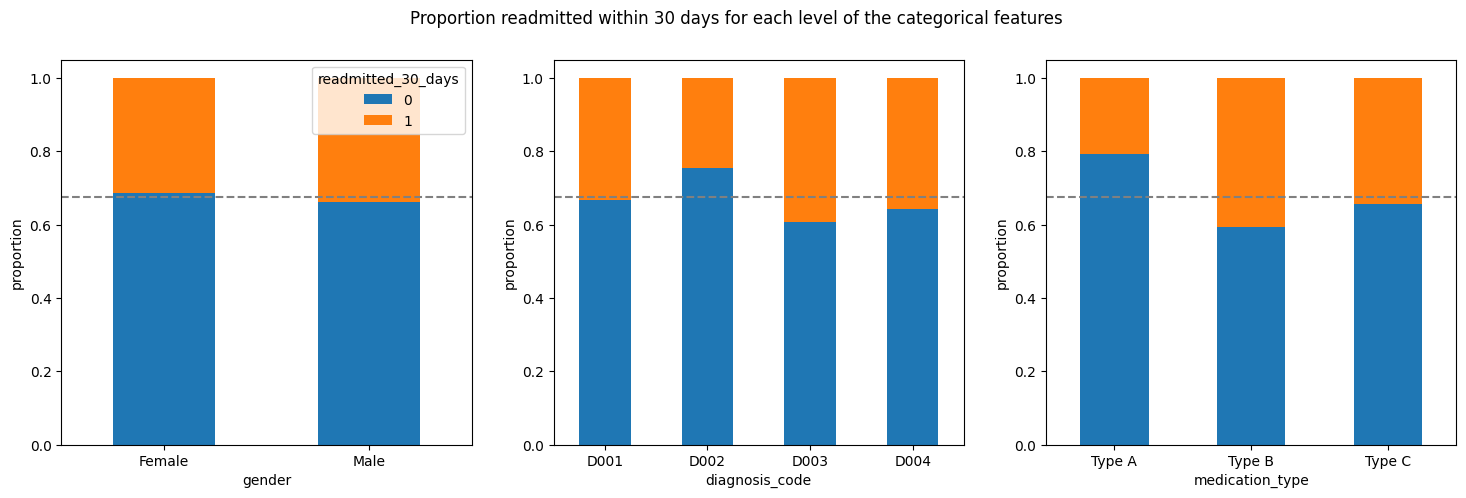

In [17]:
# Plot stacked bar charts showing the proportion of readmissions within 30 days for each level of the categorical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Proportion readmitted within 30 days for each level of the categorical features')
train_data.groupby('gender')['readmitted_30_days'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=axes[0], rot=0)
train_data.groupby('diagnosis_code')['readmitted_30_days'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=axes[1], rot=0, legend=False)
train_data.groupby('medication_type')['readmitted_30_days'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=axes[2], rot=0, legend=False)

# Calculate the base proportion not readmitted within 30 days and add it as a horizontal line for reference
base_rate = train_data['readmitted_30_days'].value_counts(normalize=True)[0]
axes[0].axhline(y=base_rate, linestyle='--', color='grey', label='Base rate not readmitted')
axes[1].axhline(y=base_rate, linestyle='--', color='grey')
axes[2].axhline(y=base_rate, linestyle='--', color='grey')

axes[0].set_ylabel('proportion')
axes[1].set_ylabel('proportion')
axes[2].set_ylabel('proportion')

There is also information relevant to readmission in some individual categorical features. For example a patient with diagnosis_code D003 or medication_type Type B is more likely to be readmitted within 30 days than baseline. A patient with diagnosis_code D002 or medication_type Type A is more likely to be readmitted within 30 days than baseline. Sex alone does not appear to be informative about whether a patient will be readmitted (but may be informative in combination with some other features(s)). 

#### Free text (discharge note)

In [18]:
# View the unique discarge notes and their counts
train_data['discharge_note'].value_counts()

discharge_note
Blood pressure under control. Continue current medication.                 20
Patient discharged in stable condition. Recommend follow-up in 2 weeks.    20
Discharge after recovery from pneumonia. No complications observed.        19
Patient discharged with minor discomfort. Advised rest and hydration.      18
Stable post-surgery. Advised to avoid physical exertion.                   16
Symptoms controlled. Monitoring for relapse advised.                       16
Good recovery trajectory. Follow-up scan scheduled next month.             14
No further signs of infection. Resume normal diet and activity.            13
Mild reaction to medication. Switched to alternative treatment.            12
Patient showed improvement. Prescribed antibiotics for 5 days.             12
Name: count, dtype: int64

In [19]:
# View the proportion of readmissions within 30 days for each unique discharge note
train_data.groupby('discharge_note')['readmitted_30_days'].value_counts(normalize=True)

discharge_note                                                           readmitted_30_days
Blood pressure under control. Continue current medication.               1                     0.550000
                                                                         0                     0.450000
Discharge after recovery from pneumonia. No complications observed.      0                     0.684211
                                                                         1                     0.315789
Good recovery trajectory. Follow-up scan scheduled next month.           0                     0.642857
                                                                         1                     0.357143
Mild reaction to medication. Switched to alternative treatment.          0                     0.750000
                                                                         1                     0.250000
No further signs of infection. Resume normal diet and activity.          0  

There are 10 unique discharge notes, and they appear to be informative on their own about readmission. Some discharge notes, for example <i>"Blood pressure under control. Continue current medication."</i> and <i>"Symptoms controlled. Monitoring for relapse advised."</i> are associated with higher than baselines rates of readmission, while others (e.g. <i>"No further signs of infection. Resume normal diet and activity."</i> and <i>"Patient discharged with minor discomfort. Advised rest and hydration."</i>) are associated with lower than baseline (0.675) rates of readmission.

Given the low cardinality, these discharge notes could be treated as a categorical and one-hot encoded. However, they do not read like (for example) options from a drop down list and are described as "free-text" in the assigment briefing. Therefore, given predictive value based on the breakdown above, I decided to generate features based on the free-text using TF-IDF - this will give one feature per word (except for stop-words which will be removed). The vocabulary is relatively small, so this seems reasonable for the current data. For a larger corpus, with a larger vocabulary, dimensionality reduction could subsequently be applied to the TF-IDF features. 

### Define classification model pipeline

I selected a random forest classifier because it is a simple model that often provides a good baseline for tabular data tasks. Additionally, I identified that there is not a monotonic relationship between age and the probability of admission (also potentially length_of_stay) - this means than an alternative simple baseline, logistic regression, would require more manual feature engineering to make proper use of these features (e.g. age > 30, age < 70) while random forest will find such splits automatically if they are useful. 

There is no benefit to scaling numeric features when using a random forest, and no missing data to impute, so numeric features are passed through the preprocessing pipeline unchanged.

All of the categorical features are low cardinality, and are therefore one-hot encoded. There is no missing data to impute.

As described above, TF-IDF features are created for the free-test discharge notes (with English stop words removed first).

In [20]:
# Lists of feature column by type, each preprocessed differently
numeric_feature_cols = ['age', 'num_previous_admissions', 'length_of_stay']
categorical_feature_cols = ['gender', 'diagnosis_code', 'medication_type']
note_col = ['discharge_note']


def make_pipeline(hyperparameters: dict, numeric_feature_cols: list = numeric_feature_cols, categorical_feature_cols: list = categorical_feature_cols, note_col: list = note_col) -> Pipeline:
    """Make a scikit-learn pipeline for readmission prediction, incluidng preprocessing steps"""

    # Numeric features passed through without transformation
    numeric_transformer = Pipeline(steps=[("passthrough", FunctionTransformer(func=lambda x: x, feature_names_out="one-to-one"))])

    # Categorical features one-hot encoded
    categorical_transformer = Pipeline(
            steps=[
                (
                    "one_hot",
                    OneHotEncoder(handle_unknown="ignore", categories="auto"),
                )
            ]
        )

    # Text features represented using TF-IDF, with stop words removed
    text_transformer = Pipeline(steps=[("single_column", FunctionTransformer(lambda x: x[note_col[0]], feature_names_out="one-to-one")),
    ("tfidf", TfidfVectorizer(stop_words="english"))])

    preprocessor = ColumnTransformer(
            transformers=[
            ("num", numeric_transformer, numeric_feature_cols),
            ("cat", categorical_transformer, categorical_feature_cols),
            ("note", text_transformer, note_col),
            ], 
        )

    classifier = RandomForestClassifier()

    model_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("clf", classifier)]
    )
    model_pipeline.set_params(**hyperparameters)

    return model_pipeline

### Tune hyperparameters using cross-validation

I ran 5-fold cross-validation using stratified folds (so each fold has approximately the same proportion of positive and negative examples). I used F1-score to evaluate performance, balancing precision and recall because we don't know how the prediction will be used or have any information about the relative costs of errors in either direction.

Candidate hyperparameters are selected based on the performance of previous trials using Bayesian optimization (with Optuna's default TPESampler).

Hyperparameter tuning is logged with mlflow so the results can be inspected. This code uses local file storage to record the runs, and the mlflow browser UI can be used to view the results by running the terminal command `mlflow ui` in the directory where this notebook was run.

In [21]:
# Create mlflow experiment if it doesn't already exist
experiment_name = "readmission_prediction_tuning"
if mlflow.get_experiment_by_name(experiment_name) is not None:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
else:
    experiment_id = mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///home/joefarrington/careers/rldatix/mlruns/989616051324397236', creation_time=1748970725114, experiment_id='989616051324397236', last_update_time=1748970725114, lifecycle_stage='active', name='readmission_prediction_tuning', tags={}>

In [22]:
def objective(trial: optuna.Trial) -> float:
    """Objective function for hyperparameter optimization using Optuna."""
    with mlflow.start_run(nested=True):
    
        # Sample hyperparameters for this trial
        hyperparameters = {
            "clf__max_depth": trial.suggest_categorical("clf__max_depth", [2, 4, 6, 12, None]),
            "clf__n_estimators": trial.suggest_int("clf__n_estimators", low=200, high=1000, step=200),
            "clf__max_features": trial.suggest_categorical("clf__max_features", ["sqrt", "log2", None]),
            "clf__class_weight": trial.suggest_categorical("clf__class_weight", ["balanced", None]),
            "clf__min_samples_split": trial.suggest_int("clf__min_samples_split", low=2, high=20),
            "clf__min_samples_leaf": trial.suggest_int("clf__min_samples_leaf", low=1, high=10),
            "clf__random_state": SEED,
        }
        # Run stratified 5-fold cross-validation and return the mean ROC AUC score
        model_pipeline = make_pipeline(hyperparameters)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = cross_val_score(model_pipeline, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)
        
        # Log the hyperparamters and score to mlflow
        mlflow.log_params(hyperparameters)
        mlflow.log_metric("mean_f1_score", scores.mean())

    return scores.mean()

In [24]:
# Number of trials to run for hyperparameter tuning
n_trials = 25

# Run hyperparamter tuning and log results with mlflow
with mlflow.start_run():
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED)) # Seed sampler for reproducibility
    study.optimize(objective, n_trials=n_trials)
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_f1_score", study.best_value)

[I 2025-06-04 21:40:08,557] A new study created in memory with name: no-name-7cf3aeb0-a83c-4ca2-bb6d-8a1319786443


[I 2025-06-04 21:40:10,244] Trial 0 finished with value: 0.4058266879319511 and parameters: {'clf__max_depth': 12, 'clf__n_estimators': 800, 'clf__max_features': 'sqrt', 'clf__class_weight': 'balanced', 'clf__min_samples_split': 16, 'clf__min_samples_leaf': 5}. Best is trial 0 with value: 0.4058266879319511.
[I 2025-06-04 21:40:11,582] Trial 1 finished with value: 0.42365079365079367 and parameters: {'clf__max_depth': 4, 'clf__n_estimators': 800, 'clf__max_features': 'log2', 'clf__class_weight': 'balanced', 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 2}. Best is trial 1 with value: 0.42365079365079367.
[I 2025-06-04 21:40:12,585] Trial 2 finished with value: 0.4185964912280702 and parameters: {'clf__max_depth': 4, 'clf__n_estimators': 400, 'clf__max_features': 'log2', 'clf__class_weight': 'balanced', 'clf__min_samples_split': 11, 'clf__min_samples_leaf': 7}. Best is trial 1 with value: 0.42365079365079367.
[I 2025-06-04 21:40:13,400] Trial 3 finished with value: 0.42468671679

In [25]:
# Print the values of the hyperparameters that achieved the highest mean ROC AUC score over the CV folds
study.best_params

{'clf__max_depth': 2,
 'clf__n_estimators': 400,
 'clf__max_features': 'log2',
 'clf__class_weight': 'balanced',
 'clf__min_samples_split': 11,
 'clf__min_samples_leaf': 3}

### Train model with best identified hyperparameters

In [26]:
final_params = study.best_params | {"clf__random_state": SEED}
readmission_clf = make_pipeline(final_params)
readmission_clf .fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('passthrough',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function make_pipeline.<locals>.<lambda> at 0x7f1b97e06200>))]),
                                                  ['age',
                                                   'num_previous_admissions',
                                                   'length_of_stay']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function make_pipeline.<locals>.<lambda> at 0x7f1b97e06160>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  ['discharge_note'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=2,
                                        max_features='log2', min_samples_leaf=3,
                                        min_samples_split=11, n_estimators=400,
                                        random_state=5))])

### Evaluate final model on the test set

In [27]:
# Compute predictions and probabilities for the test set
y_test_pred = readmission_clf .predict(X_test)
y_test_proba = readmission_clf .predict_proba(X_test)[:, 1]

In [28]:
# Print a classification report including precision, recall, and F1-score on the test set
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79        27
           1       0.55      0.46      0.50        13

    accuracy                           0.70        40
   macro avg       0.65      0.64      0.64        40
weighted avg       0.69      0.70      0.69        40



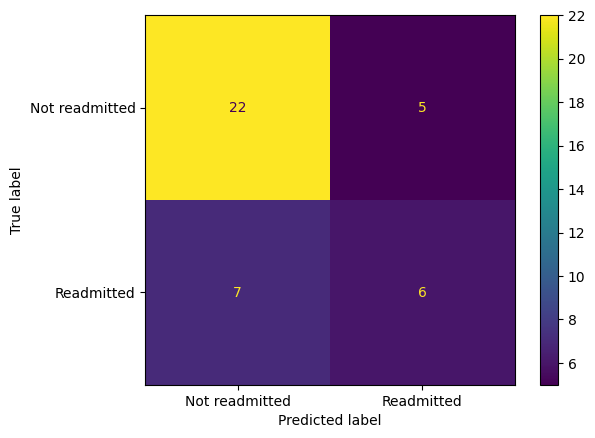

In [29]:
# Plot a confusion matrix on the test set
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = readmission_clf.classes_)
cm_plot= metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Not readmitted', 'Readmitted'])
cm_plot.plot()

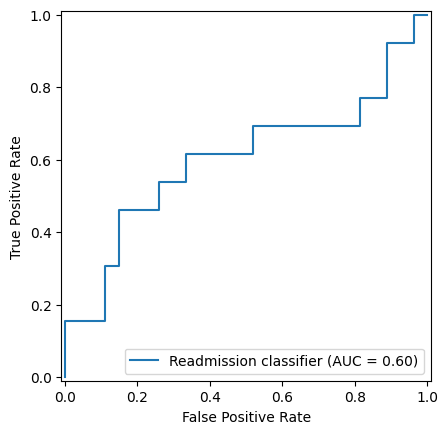

In [30]:
# Plot an ROC on the test set
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_proba, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
roc_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Readmission classifier')
roc_plot.plot()

### Explain which features were most influential using permutation feature importance

Based on: https://scikit-learn.org/stable/modules/permutation_importance.html

I calculated permutation feature importance with F1-score as the scoring metric, so the feature importance value assigned to a feature is the mean decrease in F1-score when that feature is permuted, relative to the baseline score calculated with the observed instances. The mean is calculated over 50 different permutations.  

In [31]:
def plot_permutation_feature_importance(clf: Pipeline, X: pd.DataFrame, y: pd.Series, scoring: str, n_repeats: int, random_state: int, ax: plt.Axes = None) -> plt.Axes:
    """Compute permutation feature importance for a scikit-learn pipeline and plot the results as a boxplot."""
    # Compute permuation importance
    r = permutation_importance(clf, X, y, scoring=scoring,
                            n_repeats=n_repeats,
                            random_state=random_state, n_jobs=-1)

    # Order the features by mean importance, and show the standard deviation of the estimate over the repeats
    for i in r.importances_mean.argsort()[::-1]:
        print(f"{X_train.columns[i]}:  "
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
        
    # Plot the feature importance values
    ax = sns.boxplot(pd.DataFrame(r.importances.transpose(), columns=X.columns), orient='h', order=[X.columns[i] for i in r.importances_mean.argsort()[::-1]], color='lightblue', ax=ax)
    ax.axvline(x=0, linestyle='--', color='grey')
    ax.set_title(f"Permutation feature importance estimated using {n_repeats} permutations")
    ax.set_xlabel(f"Feature importance (reduction in {scoring})")
    return ax

discharge_note:  0.267 +/- 0.110
medication_type:  0.055 +/- 0.073
num_previous_admissions:  0.045 +/- 0.034
length_of_stay:  0.034 +/- 0.045
age:  0.011 +/- 0.051
gender:  0.010 +/- 0.010
diagnosis_code:  -0.025 +/- 0.046


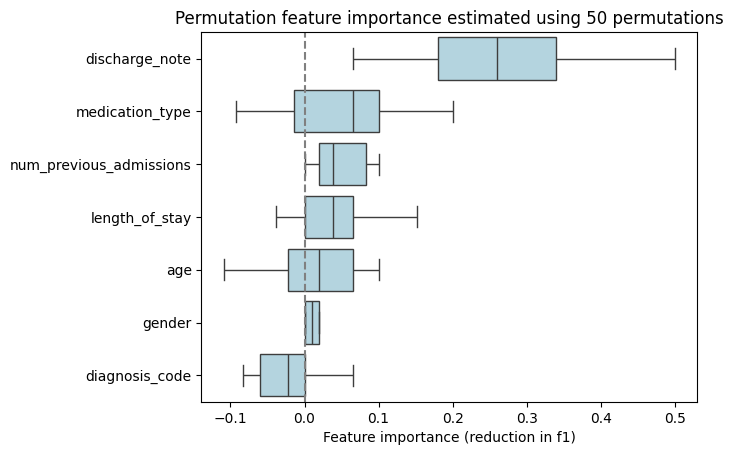

In [32]:
fi_plot = plot_permutation_feature_importance(clf=readmission_clf , X=X_test, y=y_test, scoring='f1', n_repeats=50, random_state=SEED)

The top three most important raw features based on test set feature importance are discharge_note, medication_type and num_previous_admissions. These appear reasonable given the EDA, all individually were clearly informative alone. The free-text feature, discharge_note, is clearly the most important and shuffling it leads to a mean reduction in F1 score of 0.267.

### Combined plot for report

discharge_note:  0.267 +/- 0.110
medication_type:  0.055 +/- 0.073
num_previous_admissions:  0.045 +/- 0.034
length_of_stay:  0.034 +/- 0.045
age:  0.011 +/- 0.051
gender:  0.010 +/- 0.010
diagnosis_code:  -0.025 +/- 0.046


Text(-0.17, -0.63, '(b)')

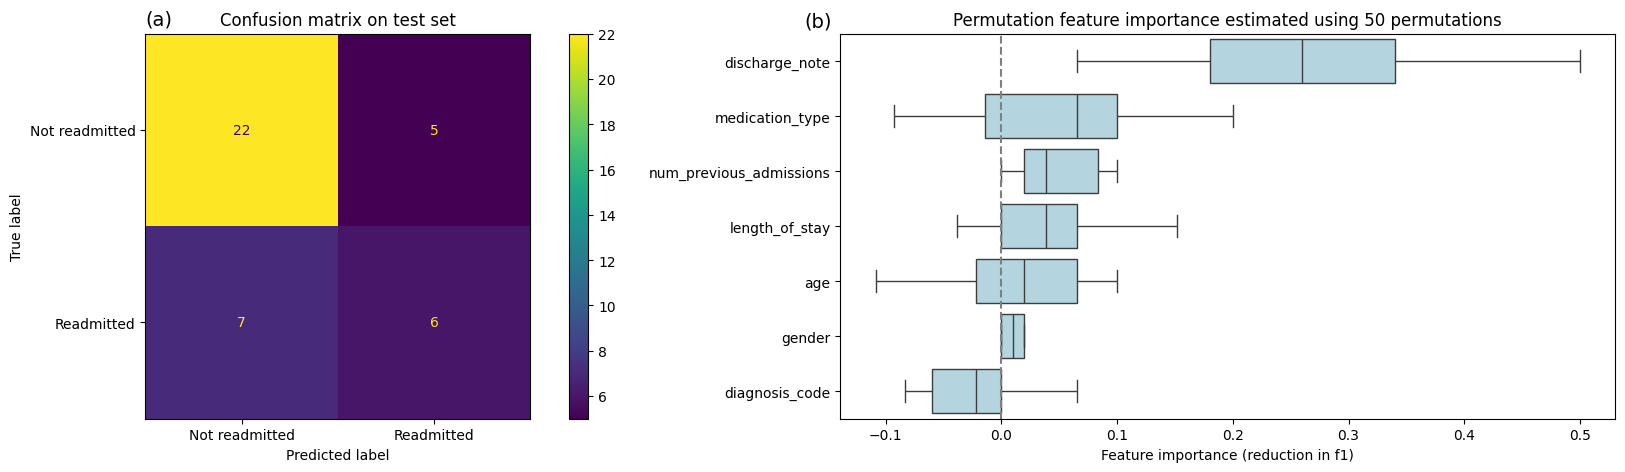

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(22, 5))
cm_plot.plot(ax=ax[0])
ax[0].set_title('Confusion matrix on test set')
plot_permutation_feature_importance(clf=readmission_clf , X=X_test, y=y_test, scoring='f1', n_repeats=50, random_state=SEED, ax=ax[1])
ax[0].text(-0.5, -0.55, "(a)", fontsize=14)
ax[1].text(-0.17, -0.63, "(b)", fontsize=14)

###

## 2. Named Entity Recognition from Discharge Notes

### Set-up

In [ ]:
from langchain_core.runnables.base import RunnableSequence
from langchain_core.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from typing import Optional
from pydantic import BaseModel, Field

### Define strucutured output and prompt template

The entities to be extracted are not standard (e.g. person, location, company) and no labelled data has been provided, so adopted a few-shot approach with an instruction fine-tuned model. A key challenge when using such a model is hallucination, both in the format/structure of the output (making it difficult to use for downstream tasks) and potentially reporting entities that do not exist in the text (versus a token-level classification named-entity recognition model which can misclassify an entity but will give a consistent output based on the provided tokens). 

Therefore, using structured output, specifying how the output should look using Pydantic. This suits the problem: we can have one key per type of entity, and a list of extracted entities of each type.

The combination of Ollama to serve the model, and Langchain for the Python interface was chosen because it supports structured outputs and because I have used both in the past. I selected Llama3.2:3b as the LLM because it is an open-source, instruction fine-tuned model and is the best Llama model available through Ollama that would run on my local GPU.

The prompt template includes examples of each entity type, and some example I created to guide the model on how to perform extraction.

In [ ]:
# Instantiate an LLM using Ollama, which has support for structured outputs
llm = ChatOllama(
    model="llama3.2:3b",
    temperature=0, # We want deterministic, not creative, responses for extracting entities
)

# Define the structured output we want the LLM to follow
class DischargeNoteEntities(BaseModel):
    """Entities to extract from patient discharge note."""
    diagnosis: list[str]
    treatment: list[str]
    symptoms: list[str]
    medications: list[str]
    follow_up: list[str]

# Tell the LLM we want the output to follow the structure of the DischargeNoteEntities model
structured_llm = llm.with_structured_output(DischargeNoteEntities)

In [ ]:
# Define a reusable prompt template, including few-shot examples
template =  """
            You will be provided with a discharge note from a patient's stay in hospital. Your task is to identify the spans of the note that
            correspond to the following entities: diagnosis, treatment, symptoms, medications, and follow-up actions.

            Diagnosis refers to diseases or other specific medical conditions mentioned in the note.

            Treatment refers to procedures or interventions that are mentioned in the note, such as surgeries or therapies (excluding medications which have their own entity).

            Symptoms refers to signs of disease or complaints that a patient has, such as a rash, pain, or fever (including adjectives like "severe" or "mild").

            Medications refers to any drugs or substances that are mentioned in the note, including painkillers and antibiotics.

            Follow-up refers to any plans for ongoing care and future appointments after discharge, and advice given to the patient about actions they should take
            after leaving the hospital to help with their recovery (e.g. when to attend a follow-up appointment, things to do and things to avoid).

            Include medications only in the medications entity, rather than as both medications and treatment.

            For each entity you should return a list of strings, where each string is a verbatim extract from the patient note that corresponds to that entity.
            If an entity is not present in the note, return an empty list for that entity.

            Below are some example extractions to guide you:

            ## Start of examples:

            Example 1:
            Patient note: "The patient came in with chest pain and fatigue, we determined it was due to pneumonia. They were treated with antibiotics 
            and advised to rest. Follow-up in one week."
            Output:
            {{
                "diagnosis": ["pneumonia"],
                "treatment": [],
                "symptoms": ["chest pain", "fatigue"],
                "medications": ["antibiotics],
                "follow_up": ["Follow-up in one week"]
            }}

            Example 2:
            Patient note: "Admitted for hip replacement surgery due to osteoarthritis. Patient developed an infection post-surgery and was prescribed a 14-day course of antibiotics."
            {{
                "diagnosis": ["osteoarthritis", "infection"],
                "treatment": ["hip replacement surgery"],
                "symptoms": [],
                "medications": ["antibiotics"],
                "follow_up": []
            }}

            Example 3:
            Patient note: "Discharged after recovery from UTI. Given antibiotics and ibuprofen for pain. Follow-up visit with GP in 10 days."
            {{
                "diagnosis": ["UTI"],
                "treatment": [],
                "symptoms": [],
                "medications": ["antibiotics", "ibuprofen"],
                "follow_up": ["Follow-up visit with GP in 10 days"]
            }}

            ## End of examples

            The patient note you need to extract the information from is:
            ```{patient_note}```
            """
prompt = PromptTemplate.from_template(template)

In [ ]:
# Input discharge notes are first added to the prompt template, and full prompt then given to the LLM
chain = prompt | structured_llm

In [ ]:
def extract_entities_from_note(patient_note: str, chain: RunnableSequence) -> DischargeNoteEntities:
    """Extract entities from a patient discharge note."""
    return chain.invoke({"patient_note": patient_note})

I added an additional validation check to ensure that the entities have not been hallucinated by checking that they are verbatim extracts from the provided discharage note.

In [ ]:
def validate_entities(entities: DischargeNoteEntities, discharge_note: str) -> tuple[bool, list[str]]:
    """Check if all extracted entities are verbatim extracts from the discharge note."""
    errors = []
    for entity, values in entities.model_dump().items():
        for v in values:
            # Case-insensitive comparison between note and extracted entities
            if v.lower() not in discharge_note.lower():
                errors.append(f"Entity '{entity}', value '{v}' not verbatim extract from discharge note.")
    return len(errors) == 0, errors

### Test the named entity recognition and validation on some simple examples

In [ ]:
# Create a new example note and model answer for evaluation
example_note = "The patient was admitted with headaches and nausea. After tests, we diagnosed them with a migraine. They were prescribed painkillers and advised to rest. Follow-up in two weeks."
example_model_answer = DischargeNoteEntities(
    diagnosis=["migraine"],
    treatment=[],
    symptoms=["headaches", "nausea"],
    medications=["painkillers"],
    follow_up=["Follow-up in two weeks"]
)

In [ ]:
# Run the extraction and validation on the example note and compare to the model answer
extracted_entities = extract_entities_from_note(example_note, chain)
is_valid, validation_errors = validate_entities(extracted_entities, example_note)
print("Extracted entities:", extracted_entities)
print("Matches model answer:", extracted_entities == example_model_answer)
print("Valid extraction:", is_valid)
if not is_valid:
    print("Validation errors:", validation_errors)


Extracted entities: diagnosis=['migraine'] treatment=[] symptoms=['headaches', 'nausea'] medications=['painkillers'] follow_up=['Follow-up in two weeks']
Matches model answer: True
Valid extraction: True


In [ ]:
# Create an invalid example to test that the validation function correctly identifies errors
example_note = "The patient was admitted with severe headaches and nausea. After tests, we diagnosed them with a migraine. They were treated with painkillers and advised to rest. Follow-up in two weeks."
example_model_answer = DischargeNoteEntities(
    diagnosis=["migraine"],
    treatment=[],
    symptoms=["severe headaches", "nausea"],
    medications=["painkillers"],
    follow_up=["Follow-up in two weeks"]
)

invalid_entities = DischargeNoteEntities(
    diagnosis=["migraine"],
    treatment=[],
    symptoms=["severe headaches", "nausea", "dizziness"],  # Dizziness should not be in symptoms
    medications=["antibiotics"],  # Antibiotics should not be in medications, painkillers should be
    follow_up=["Follow-up in two weeks"]
)
is_valid, validation_errors = validate_entities(invalid_entities, example_note)
print("Matches model answer:", invalid_entities == example_model_answer)
print("Valid extraction:", is_valid)
if not is_valid:
    print("Validation errors:", validation_errors)

Matches model answer: False
Valid extraction: False
Validation errors: ["Entity 'symptoms', value 'dizziness' not verbatim extract from discharge note.", "Entity 'medications', value 'antibiotics' not verbatim extract from discharge note."]


This shows that the pipeline can perform named entity recognition, that the structured output is being enforced, and that the validation function correctly identifies hallucinated entities.


### Apply the named entity recognition pipeline to the provided discharge notes

All the notes are repeated multiple times in the orginal dataset, so just apply once to each unique discharge note.

In [ ]:
discharge_notes = data['discharge_note'].unique()

In [ ]:
discharge_notes

array(['Good recovery trajectory. Follow-up scan scheduled next month.',
       'Stable post-surgery. Advised to avoid physical exertion.',
       'Symptoms controlled. Monitoring for relapse advised.',
       'Discharge after recovery from pneumonia. No complications observed.',
       'Patient discharged in stable condition. Recommend follow-up in 2 weeks.',
       'Patient showed improvement. Prescribed antibiotics for 5 days.',
       'Blood pressure under control. Continue current medication.',
       'Patient discharged with minor discomfort. Advised rest and hydration.',
       'No further signs of infection. Resume normal diet and activity.',
       'Mild reaction to medication. Switched to alternative treatment.'],
      dtype=object)

In [ ]:
# Apply the LLM chain to each of the provide discharge notes, recording the output and any errors from out validation function
entities_list = []
is_valid_list = []
validation_errors_list = []

for note in discharge_notes:
    entities = extract_entities_from_note(note, chain)
    is_valid, validation_errors = validate_entities(entities, note)
    entities_list.append(entities)
    is_valid_list.append(is_valid)
    validation_errors_list.append(validation_errors)

In [ ]:
# Check if the extraction was valid for all notes
all(is_valid_list)

True

In [ ]:
# Print pairs of discharge notes and their extracted entities
for i in range(len(entities_list)):
    print(f"Discharge Note {i+1}:")
    print("Note:", discharge_notes[i])
    print("Extracted entities:", entities_list[i])
    print("")

Discharge Note 1:
Note: Good recovery trajectory. Follow-up scan scheduled next month.
Extracted entities: diagnosis=[] treatment=[] symptoms=[] medications=[] follow_up=['Follow-up scan scheduled next month.']

Discharge Note 2:
Note: Stable post-surgery. Advised to avoid physical exertion.
Extracted entities: diagnosis=[] treatment=[] symptoms=['physical exertion'] medications=[] follow_up=[]

Discharge Note 3:
Note: Symptoms controlled. Monitoring for relapse advised.
Extracted entities: diagnosis=[] treatment=[] symptoms=['Symptoms controlled'] medications=[] follow_up=[]

Discharge Note 4:
Note: Discharge after recovery from pneumonia. No complications observed.
Extracted entities: diagnosis=['pneumonia'] treatment=[] symptoms=[] medications=[] follow_up=[]

Discharge Note 5:
Note: Patient discharged in stable condition. Recommend follow-up in 2 weeks.
Extracted entities: diagnosis=[] treatment=[] symptoms=[] medications=[] follow_up=['Recommend follow-up in 2 weeks.']

Discharge 

No labels were provided for these discharge notes and therefore I have not computed any metrics (e.g. precision and recall for the entities) on the cases. I considered labelled them myself, but there is some ambiguity and several entities are not well represented (e.g. pneumonia appears to be the only diagnosis), so I did not think the metrics would be informative. The examples above show that there is certainly room for improvement, but a fully labelled set of evaluation examples is needed to quantity the results and guide subsequent prompt engineering etc. 

My efforts to stop hallucination were successful on these 10 notes - the structured output has been enforced and the validation check shows that all of the extracted entities are verbatim extracts from the associated discharge note even if they may have been misclassified. 

There are several examples in the provided discharge notes where an extracted entity is related to a concept but not really an entity, for example "Continue current medication" is extracted as a medication for note 7, but this should probably be considered a follow-up action and doesn't mention a specific mediation. Similarly, "alternative treatment" has been identified (reasonably) as a treatment, but is not a useful treatment to extract.

Using a general purpose, instruction fine-tuned LLM enables a working proof-of-concept to be quickly developed simply be describing each entity and providing some examples of extraction. However, the model has been trained on a general corpus and may still not apply these terms in the way they would be meant by a medical professional, and may have a limited understanding of specific medical terminology. Fine-tuning either a general purpose LLM on a medical corpus, or a token-level classification model using medical examples of these specific entities, could lead to improved performance (or, at least, performance that matches a much larger, more expensive general purpose model).